In [1]:
# import Library
import glob
import pandas as pd
import numpy as np
import os

# 0. Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load Dataset

In [3]:
DATA_DIR = '/content/drive/MyDrive/CICIDS2017'

In [4]:
# baca csv file
csv_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

# buat dataframe
all_frame = []
for f_path in csv_files:
  df = pd.read_csv(f_path)
  print(f"{os.path.basename(f_path)}: {df.shape}")
  all_frame.append(df)

# hapus variabel yang tidak di perlukan
del csv_files
del df
del f_path

Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv: (225745, 79)
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv: (286467, 79)
Friday-WorkingHours-Morning.pcap_ISCX.csv: (191033, 79)
Monday-WorkingHours.pcap_ISCX.csv: (529918, 79)
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv: (288602, 79)
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv: (170366, 79)
Tuesday-WorkingHours.pcap_ISCX.csv: (445909, 79)
Wednesday-workingHours.pcap_ISCX.csv: (692703, 79)


In [5]:
# satukan dataframe
raw_df = pd.concat(all_frame, ignore_index=True)
print(raw_df.shape)

# hapus variable yang tidak diperlukan
del all_frame

(2830743, 79)


# 2. Data Cleaning

In [6]:
# hapus spasi dari header
raw_df.columns = raw_df.columns.str.strip()

In [7]:
# cek jumlah duplikat
print(f"Jumlah duplikat: {raw_df.duplicated().sum()}")

Jumlah duplikat: 308381


In [8]:
# hapus duplikat dan keep=first
raw_df = raw_df.drop_duplicates()
raw_df.shape

(2522362, 79)

In [9]:
# buat hash perkolom -> hash dijumlahkan -> kalo kolomnya identik hasnya akan sama
col_hash = raw_df.apply(lambda col: pd.util.hash_pandas_object(col, index=False).sum())
# buat dataframe hasil hash
df_hash = col_hash.reset_index()
df_hash.columns = ['col_name', 'hash_value']
# kumpulkan kolom yang punya hash sama
duplicate_groups = df_hash.groupby('hash_value')['col_name'].apply(list)
# panggil yang > 1
duplicate_groups = duplicate_groups[duplicate_groups.str.len() > 1]
for grup in duplicate_groups:
    print(grup)

['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
['Fwd URG Flags', 'CWE Flag Count']
['Total Fwd Packets', 'Subflow Fwd Packets']
['Total Backward Packets', 'Subflow Bwd Packets']
['Fwd PSH Flags', 'SYN Flag Count']
['Fwd Header Length', 'Fwd Header Length.1']


In [10]:
# hapus kolom duplikat
raw_df = raw_df.loc[:, ~col_hash.duplicated()]
print(raw_df.shape)
# hapus variabel yang tidak di perlukan
del col_hash
del df_hash
del duplicate_groups
del grup

(2522362, 67)


In [11]:
inf_count = (raw_df == np.inf).sum() + (raw_df == -np.inf).sum()
# panggil kolom yang inf > 0
print(inf_count[inf_count > 0])
# hapus variabel yang tidak diperlukan
del inf_count

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [12]:
# ubah inf jadi nan
raw_df = raw_df.replace([np.inf, -np.inf], np.nan)

In [13]:
# cari missing value/nan per Label -> bandingkan setelah di hapus
before = raw_df['Label'].value_counts()
after  = raw_df.dropna()['Label'].value_counts()

cek_label = pd.DataFrame({'Before': before, 'After': after})
cek_label['Lost'] = cek_label['Before'] - cek_label['After']
cek_label['Lost %'] = (cek_label['Lost'] / cek_label['Before'] * 100).round(2)
print(cek_label)
# hapus variabel yang tidak di perlukan
del before
del after
del cek_label

                             Before    After  Lost  Lost %
Label                                                     
BENIGN                      2096484  2095057  1427    0.07
DoS Hulk                     172849   172846     3    0.00
DDoS                         128016   128014     2    0.00
PortScan                      90819    90694   125    0.14
DoS GoldenEye                 10286    10286     0    0.00
FTP-Patator                    5933     5931     2    0.03
DoS slowloris                  5385     5385     0    0.00
DoS Slowhttptest               5228     5228     0    0.00
SSH-Patator                    3219     3219     0    0.00
Bot                            1953     1948     5    0.26
Web Attack � Brute Force       1470     1470     0    0.00
Web Attack � XSS                652      652     0    0.00
Infiltration                     36       36     0    0.00
Web Attack � Sql Injection       21       21     0    0.00
Heartbleed                       11       11     0    0.

In [14]:
# cari missing value per kolom
threshold = 10
miss_cek = raw_df.isnull().mean() * 100
high = miss_cek[miss_cek > threshold]

if high.empty: print("Tidak ada kolom yang missing lebih dari", threshold, "%")
print(miss_cek.sort_values(ascending=False).head(10))
# hapus variabel yang tidak di perlukan
del miss_cek
del high
del threshold

Tidak ada kolom yang missing lebih dari 10 %
Flow Packets/s                 0.062005
Flow Bytes/s                   0.062005
Destination Port               0.000000
Total Fwd Packets              0.000000
Flow Duration                  0.000000
Total Backward Packets         0.000000
Total Length of Fwd Packets    0.000000
Fwd Packet Length Min          0.000000
Fwd Packet Length Mean         0.000000
Total Length of Bwd Packets    0.000000
dtype: float64


In [15]:
print((raw_df.isna().mean(1) * 100).describe())
print("\nTotal baris missing value:", raw_df.isna().any(axis=1).sum())

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total baris missing value: 1564


In [16]:
# missing value tidak terlalu berarti -> hapus missing value
raw_df = raw_df.dropna()
raw_df.shape

(2520798, 67)

# 4. Seleksi FItur

In [17]:
# cek kolom yang isinya sama semua
raw_df.columns[raw_df.nunique()==1]

Index(['Bwd PSH Flags'], dtype='object')

In [18]:
# hapus kolom yang isinya sama semua
raw_df = raw_df.drop(raw_df.columns[raw_df.nunique()==1], axis=1)
raw_df.shape

(2520798, 66)

In [19]:
raw_df.sample(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1514667,53,397,2,2,72,336,36,36,36.000000,0.000000,...,32,0.0,0.000000,0,0,0.0,0.000000,0,0,BENIGN
2092723,53,215,2,2,88,250,44,44,44.000000,0.000000,...,40,0.0,0.000000,0,0,0.0,0.000000,0,0,BENIGN
2005953,63774,76,1,3,0,0,0,0,0.000000,0.000000,...,32,0.0,0.000000,0,0,0.0,0.000000,0,0,BENIGN
106761,80,376822,3,6,26,11601,20,0,8.666667,10.263203,...,20,0.0,0.000000,0,0,0.0,0.000000,0,0,DDoS
2574332,443,4052298,7,7,1637,2726,1069,0,233.857143,414.291938,...,32,0.0,0.000000,0,0,0.0,0.000000,0,0,BENIGN
268042,53,1004153,1,1,48,128,48,48,48.000000,0.000000,...,20,0.0,0.000000,0,0,0.0,0.000000,0,0,BENIGN
997861,80,23849381,6,6,454,1974,430,0,75.666667,173.603763,...,20,35734.0,16909.751565,47691,23777,9998967.5,5984.244689,10003199,9994736,BENIGN
2217889,34686,12,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.000000,0,0,0.0,0.000000,0,0,BENIGN
1896712,53,851511,2,2,52,290,26,26,26.000000,0.000000,...,20,0.0,0.000000,0,0,0.0,0.000000,0,0,BENIGN
325632,1106,16,1,1,2,6,2,2,2.000000,0.000000,...,24,0.0,0.000000,0,0,0.0,0.000000,0,0,PortScan


In [20]:
raw_df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,...,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06,2.520798e+06
mean,8.690590e+03,1.659161e+07,1.028174e+01,1.157280e+01,6.119477e+02,1.814440e+04,2.312292e+02,1.920349e+01,6.350497e+01,7.732347e+01,...,6.009478e+00,-3.082233e+03,9.157847e+04,4.619177e+04,1.720171e+05,6.546359e+04,9.337367e+06,5.657941e+05,9.763770e+06,8.892671e+06
std,1.901280e+04,3.523276e+07,7.944201e+02,1.056922e+03,1.058827e+04,2.398177e+06,7.563755e+02,6.079834e+01,1.955526e+02,2.968814e+02,...,6.744150e+02,1.149758e+06,6.866503e+05,4.165844e+05,1.085571e+06,6.111585e+05,2.484818e+07,4.874169e+06,2.561746e+07,2.458143e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.080000e+02,2.000000e+00,1.000000e+00,1.200000e+01,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.062200e+04,2.000000e+00,2.000000e+00,6.600000e+01,1.560000e+02,4.000000e+01,2.000000e+00,3.625000e+01,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,5.333340e+06,6.000000e+00,5.000000e+00,3.320000e+02,9.970000e+02,2.020000e+02,3.700000e+01,5.200000e+01,7.419280e+01,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.metrics import confusion_matrix, classification_report

# 1. dapetin fitur numerik
def get_feature_types(df, target_col='Label'):
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric: numeric.remove(target_col)
    return numeric

# 2. korelasi dan pasangan korelasi tinggi
def simple_corr(df, numeric_features, threshold=0.85, scatter_threshold=0.99):
    # matriks korelasi
    corr = df[numeric_features].corr()
    # heatmap matriks korelasi
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # pasangan korelasi
    pairs = []

    for i in range(len(corr.columns)):
        for j in range(i + 1, len(corr.columns)):
            corr_value = corr.iloc[i, j]
            if abs(corr_value) > threshold:
                f1 = corr.index[i]
                f2 = corr.columns[j]
                pairs.append((f1, f2, corr_value))
    for f1, f2, corr_value in pairs:
        print(f"{f1}  X  {f2}: {corr_value:.4f}")

    # scatter plot korelasi tinggi
    strong_pairs = []

    for f1, f2, corr_value in pairs:
        if abs(corr_value) >= scatter_threshold:
            strong_pairs.append((f1, f2, corr_value))

    if len(strong_pairs) > 0:
        n_plots = len(strong_pairs)
        n_cols = 4
        n_rows = (n_plots + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
        axes = axes.flatten()

        for i, (f1, f2, corr_value) in enumerate(strong_pairs):
            sns.scatterplot(x=df[f1], y=df[f2], ax=axes[i])
            axes[i].set_title(f"{f1} vs {f2} (Corr={corr_value:.2f})", fontsize=8)
            axes[i].set_xlabel(f1, fontsize=8)
            axes[i].set_ylabel(f2, fontsize=8)

        # Hapus subplot yang kosong kalau jumlah pair tidak pas dengan grid
        for j in range(len(strong_pairs), len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

    return corr, pairs



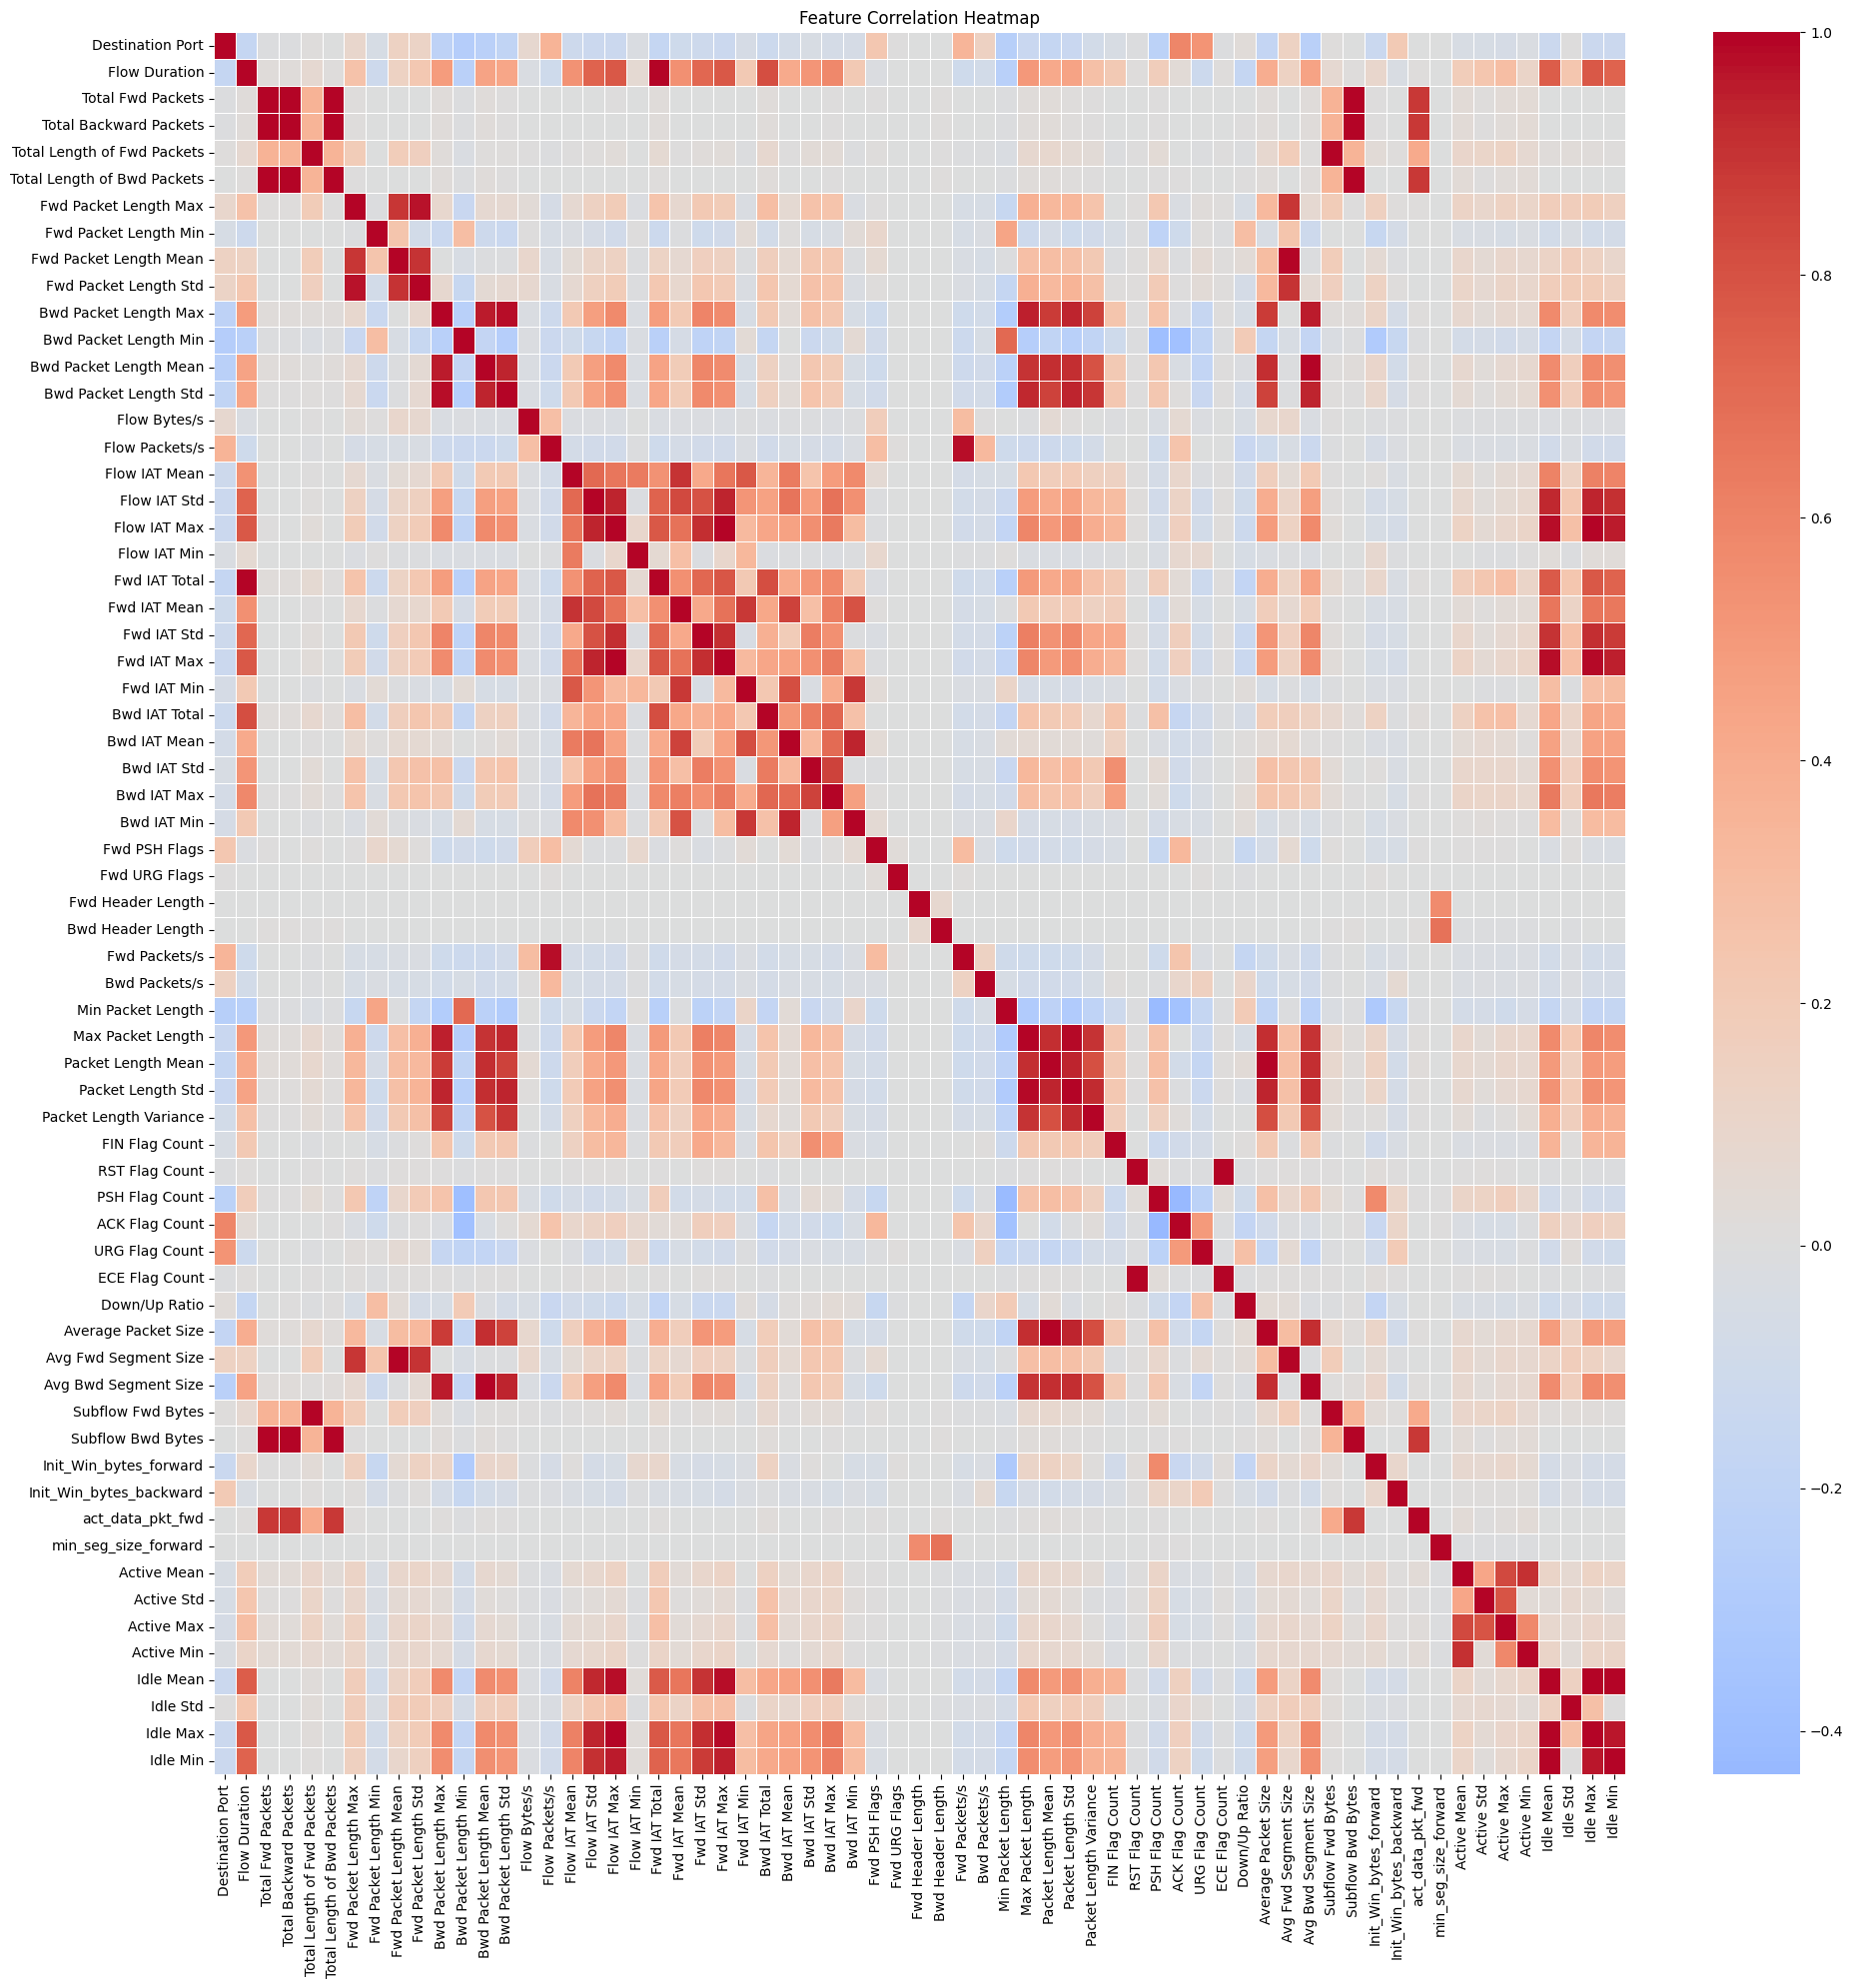

Flow Duration  X  Fwd IAT Total: 0.9985
Total Fwd Packets  X  Total Backward Packets: 0.9991
Total Fwd Packets  X  Total Length of Bwd Packets: 0.9970
Total Fwd Packets  X  Subflow Bwd Bytes: 0.9970
Total Fwd Packets  X  act_data_pkt_fwd: 0.8874
Total Backward Packets  X  Total Length of Bwd Packets: 0.9944
Total Backward Packets  X  Subflow Bwd Bytes: 0.9944
Total Backward Packets  X  act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets  X  Subflow Fwd Bytes: 1.0000
Total Length of Bwd Packets  X  Subflow Bwd Bytes: 1.0000
Total Length of Bwd Packets  X  act_data_pkt_fwd: 0.8840
Fwd Packet Length Max  X  Fwd Packet Length Mean: 0.8889
Fwd Packet Length Max  X  Fwd Packet Length Std: 0.9685
Fwd Packet Length Max  X  Avg Fwd Segment Size: 0.8889
Fwd Packet Length Mean  X  Fwd Packet Length Std: 0.8976
Fwd Packet Length Mean  X  Avg Fwd Segment Size: 1.0000
Fwd Packet Length Std  X  Avg Fwd Segment Size: 0.8976
Bwd Packet Length Max  X  Bwd Packet Length Mean: 0.9582
Bwd Packet Length Ma

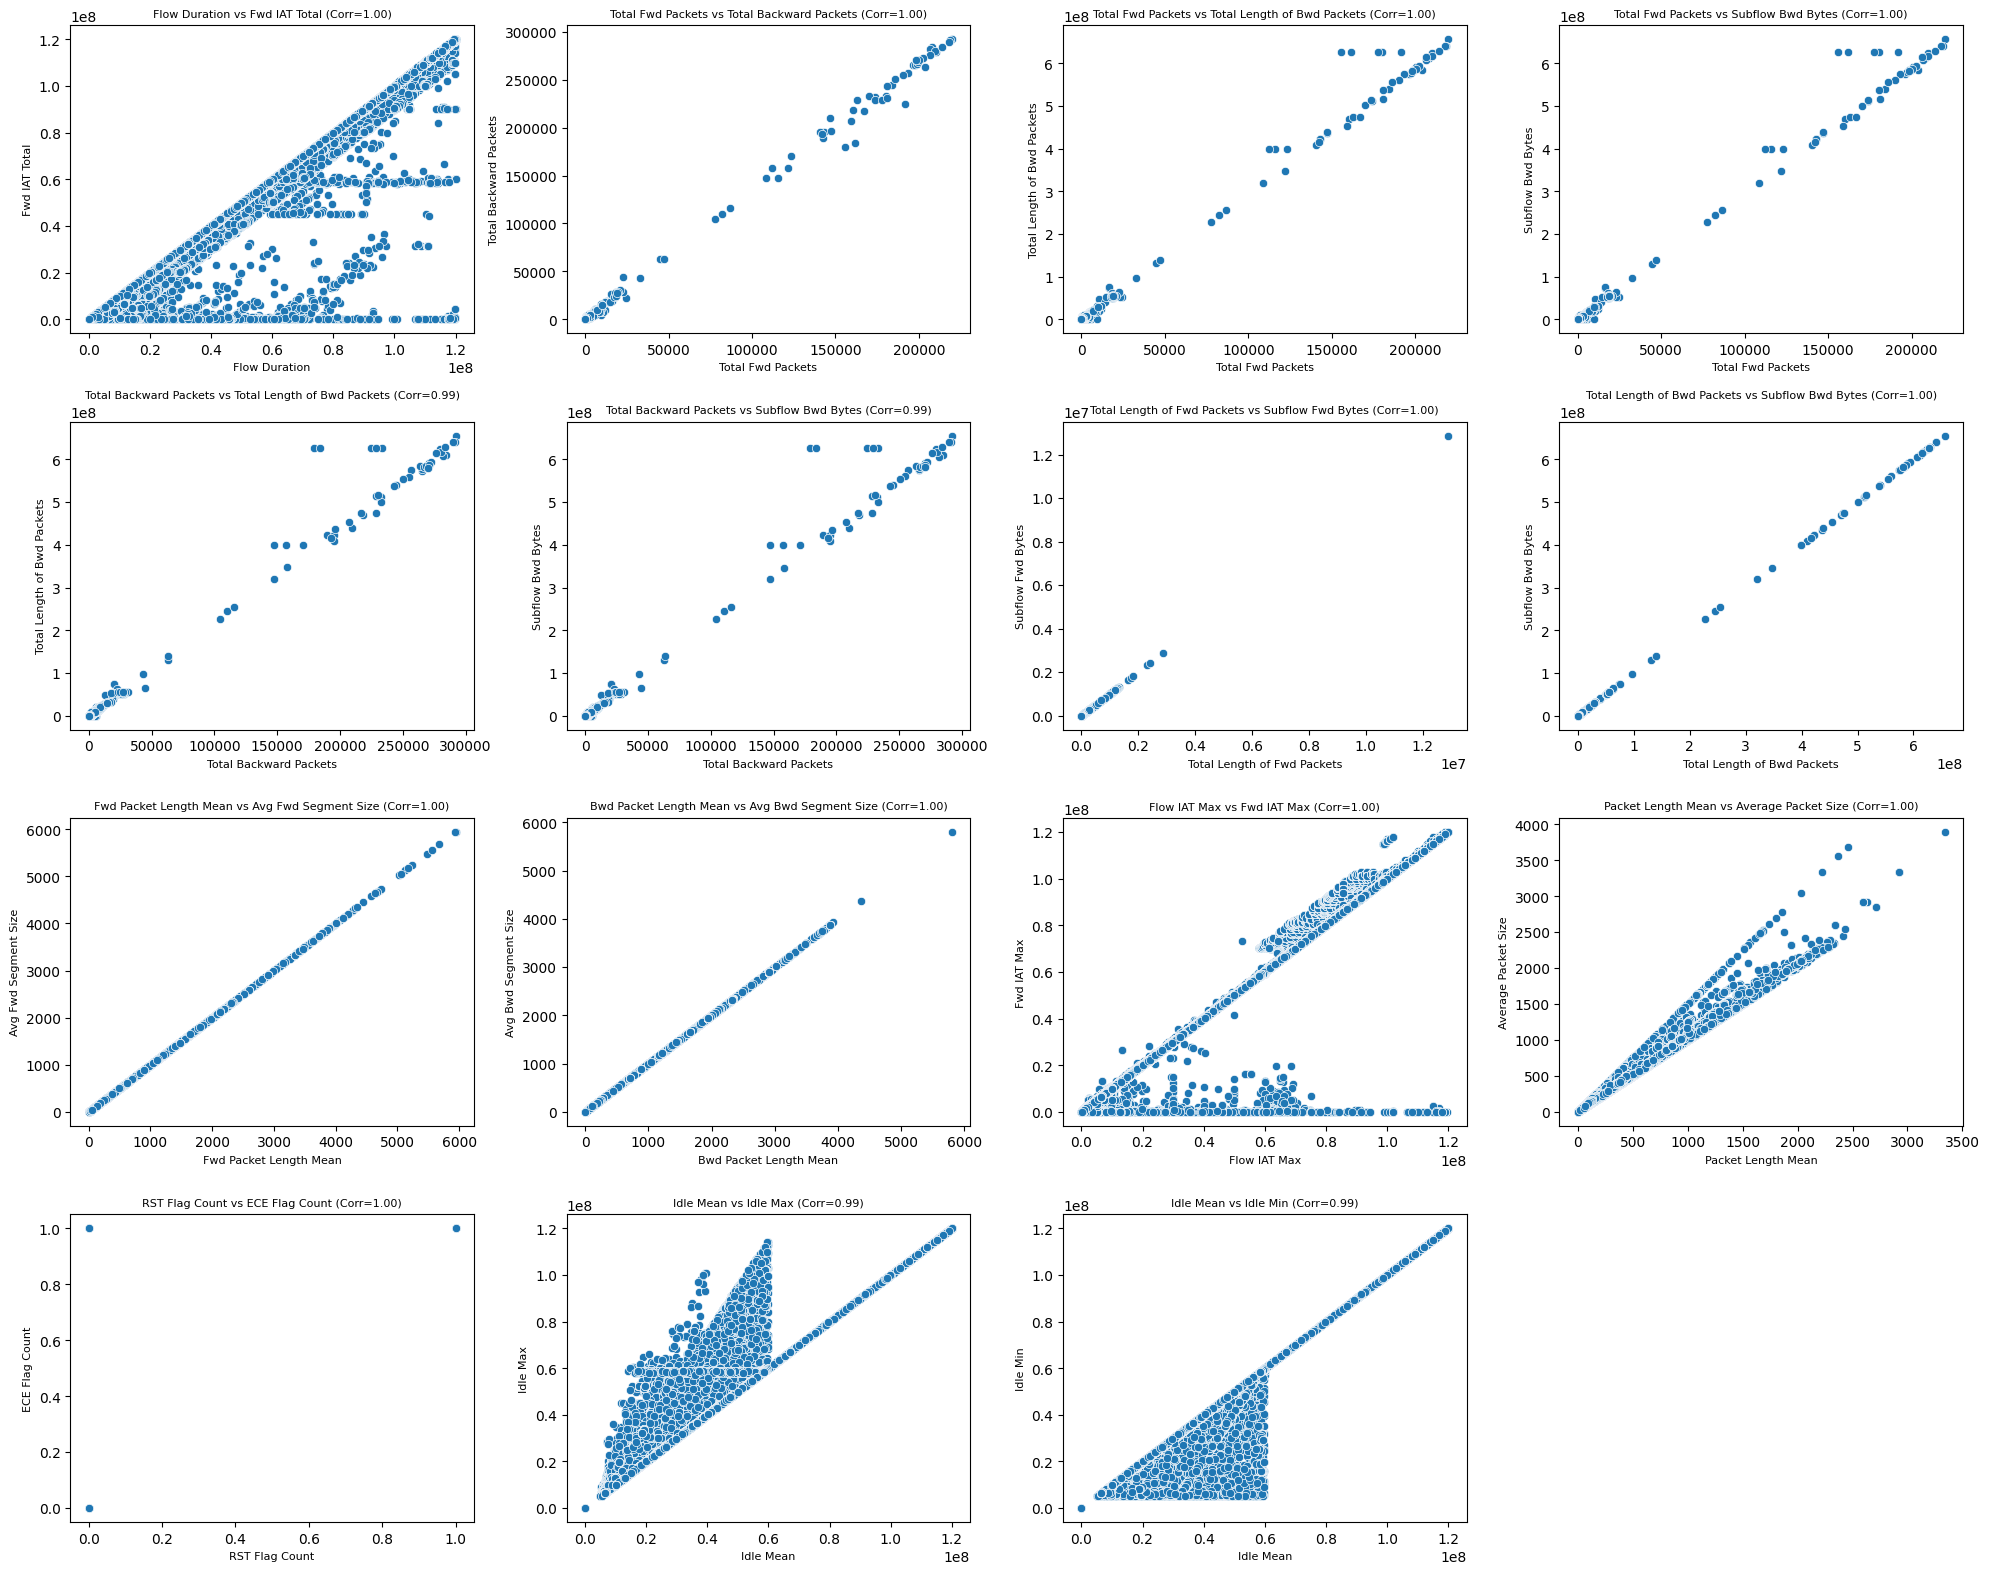

In [22]:
num_features = get_feature_types(raw_df)
corr_matrix, high_corr_pairs = simple_corr(raw_df, num_features)


In [23]:
'''
jika dilihat terdapat fitur yang memiliki bentuk yang mirip/kembar
Total Fwd Packets x Total Length of Bwd Packets
Total Fwd Packets x Subflow Bwd Bytes
Total Backward Packets x Total Length of Bwd Packets
Total Backward Packets x Subflow Bwd Bytes

berupa scaterplot lurus pada
Total Fwd Packets x Total Backward Packets
Total Length of Bwd Packets x Subflow Bwd Bytes
Fwd Packet Length Mean x Avg Fwd Segment Size
Bwd Packet Length Mean x Avg Bwd Segment Size

sehingga dapat dihapus
Avg Fwd Segment Size, Avg Bwd Segment Size, Subflow Bwd Bytes, Total Length of Bwd Packets, Total Backward Packets
'''
# drop fitur yang dipilh
raw_df = raw_df.drop(columns=[
    'Avg Fwd Segment Size',
    'Avg Bwd Segment Size',
    'Subflow Bwd Bytes',
    'Total Length of Bwd Packets',
    'Total Backward Packets'
])
raw_df.shape

(2520798, 61)

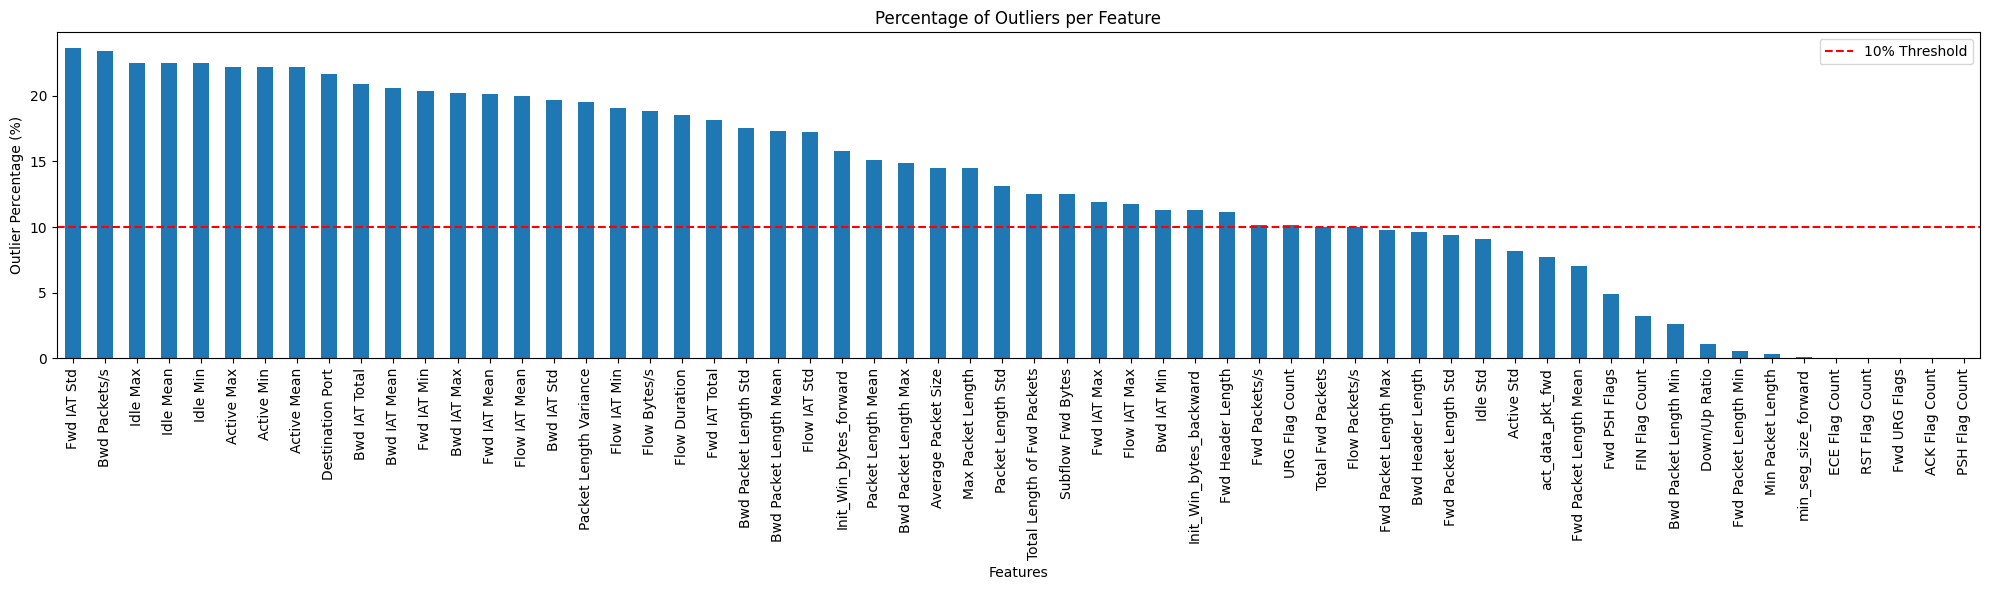

,0
Fwd IAT Std,23.658302
Bwd Packets/s,23.401954
Idle Max,22.502200
Idle Mean,22.502200
Idle Min,22.502200
Active Max,22.168575
Active Min,22.168575
Active Mean,22.168575
Destination Port,21.644733
Bwd IAT Total,20.928055


In [24]:
# cek outlier -> mentukan scaler
def simple_outlier(df, fitur, threshold=10):
    out = {}
    for col in fitur:
        s = df[col].dropna()
        if s.empty:
            out[col] = 0.0
            continue
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        out[col]= ((s < low) | (s > high)).mean() * 100

    out = pd.Series(out).sort_values(ascending=False)

    plt.figure(figsize=(20, 6))
    out.plot(kind='bar')

    plt.axhline(threshold, color='red', linestyle='--', label=f'{threshold}% Threshold')
    plt.title("Percentage of Outliers per Feature")
    plt.ylabel("Outlier Percentage (%)")
    plt.xlabel("Features")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return out

num_features = get_feature_types(raw_df)
simple_outlier(raw_df, num_features)


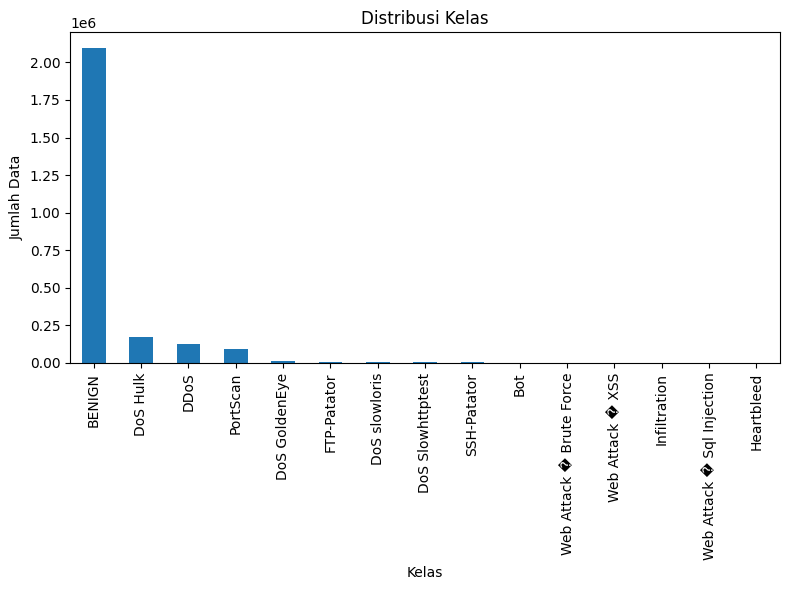

,Jumlah,Persen (%)
Label,,
BENIGN,2095057,83.11
DoS Hulk,172846,6.86
DDoS,128014,5.08
PortScan,90694,3.60
DoS GoldenEye,10286,0.41
FTP-Patator,5931,0.24
DoS slowloris,5385,0.21
DoS Slowhttptest,5228,0.21
SSH-Patator,3219,0.13


In [25]:
# cek imbalance
def simple_imbalance(df, col_label="Label"):
    class_count = df[col_label].value_counts()
    pct = (class_count / len(df) * 100).round(2)

    imbalance = pd.DataFrame({
        "Jumlah": class_count,
        "Persen (%)": pct
    })
    # plot batang
    plt.figure(figsize=(8,6))
    class_count.plot(kind="bar")
    plt.title("Distribusi Kelas")
    plt.ylabel("Jumlah Data")
    plt.xlabel("Kelas")
    plt.tight_layout()
    plt.show()

    return imbalance
simple_imbalance(raw_df, "Label")

In [26]:
# cek levene -> menentukan cariansi antar kelas homogen atau tidak
def simple_levene(df, numeric_features, target_col='Label'):
    res = {}
    groups_df = list(df.groupby(target_col))
    for f in numeric_features:
        groups = [g[f].dropna().values for _, g in groups_df]
        groups = [g for g in groups if len(g) > 0 and np.var(g) > 0]
        if len(groups) < 2:
            continue
        stat, p = stats.levene(*groups)
        res[f] = {'stat': stat, 'p': p}
    return pd.DataFrame(res).T.sort_values('p')

simple_levene(raw_df, num_features)

,stat,p
Destination Port,8607.456863,0.000000e+00
Flow Duration,3339.470632,0.000000e+00
Total Length of Fwd Packets,3342.507036,0.000000e+00
Fwd Packet Length Max,1836.209661,0.000000e+00
Fwd Packet Length Mean,1418.050261,0.000000e+00
Fwd Packet Length Min,4808.905868,0.000000e+00
Fwd Packet Length Std,1260.577594,0.000000e+00
Bwd Packet Length Max,92144.535749,0.000000e+00
Flow Packets/s,1396.389323,0.000000e+00
Bwd Packet Length Min,26441.270691,0.000000e+00


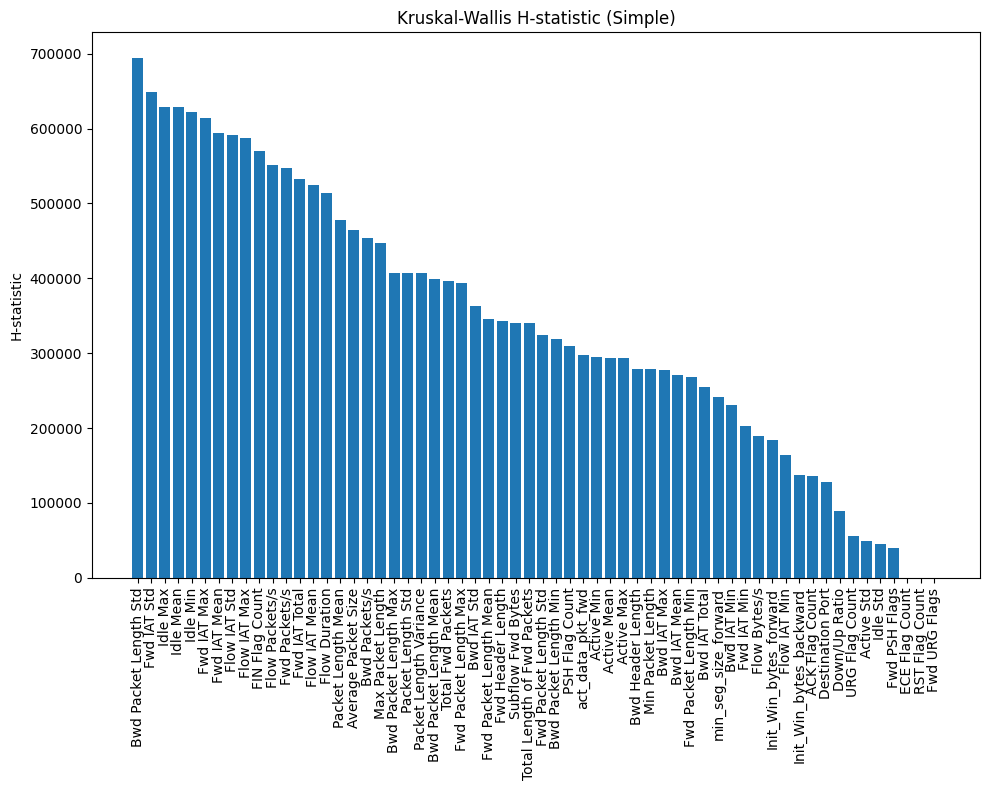

In [27]:
# caek fitur importance
def simple_kw(df, numeric_features, target_col='Label'):
    res = {}
    groups_df = list(df.groupby(target_col))
    for f in numeric_features:
        groups = [g[f].dropna().values for _, g in groups_df]
        if sum(len(g) > 0 for g in groups) < 2:
            continue
        h, p = stats.kruskal(*groups)
        res[f] = {'H': h, 'p': p}

    df_kw = pd.DataFrame(res).T
    df_kw = df_kw.sort_values('H', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.bar(df_kw.index, df_kw['H'])
    plt.xticks(rotation=90)
    plt.ylabel("H-statistic")
    plt.title("Kruskal-Wallis H-statistic (Simple)")
    plt.tight_layout()
    plt.show()

    return df_kw

df_kw = simple_kw(raw_df, num_features)

In [28]:
fitur_kecil = df_kw.nsmallest(10, 'H').index.tolist()
print(fitur_kecil)

['Fwd URG Flags', 'RST Flag Count', 'ECE Flag Count', 'Fwd PSH Flags', 'Idle Std', 'Active Std', 'URG Flag Count', 'Down/Up Ratio', 'Destination Port', 'ACK Flag Count']


--- Memulai Random Forest Feature Importance ---
Menggunakan sampel data: (252079, 60) untuk kalkulasi importance.


/tmp/ipython-input-4265059495.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_df, palette='viridis')


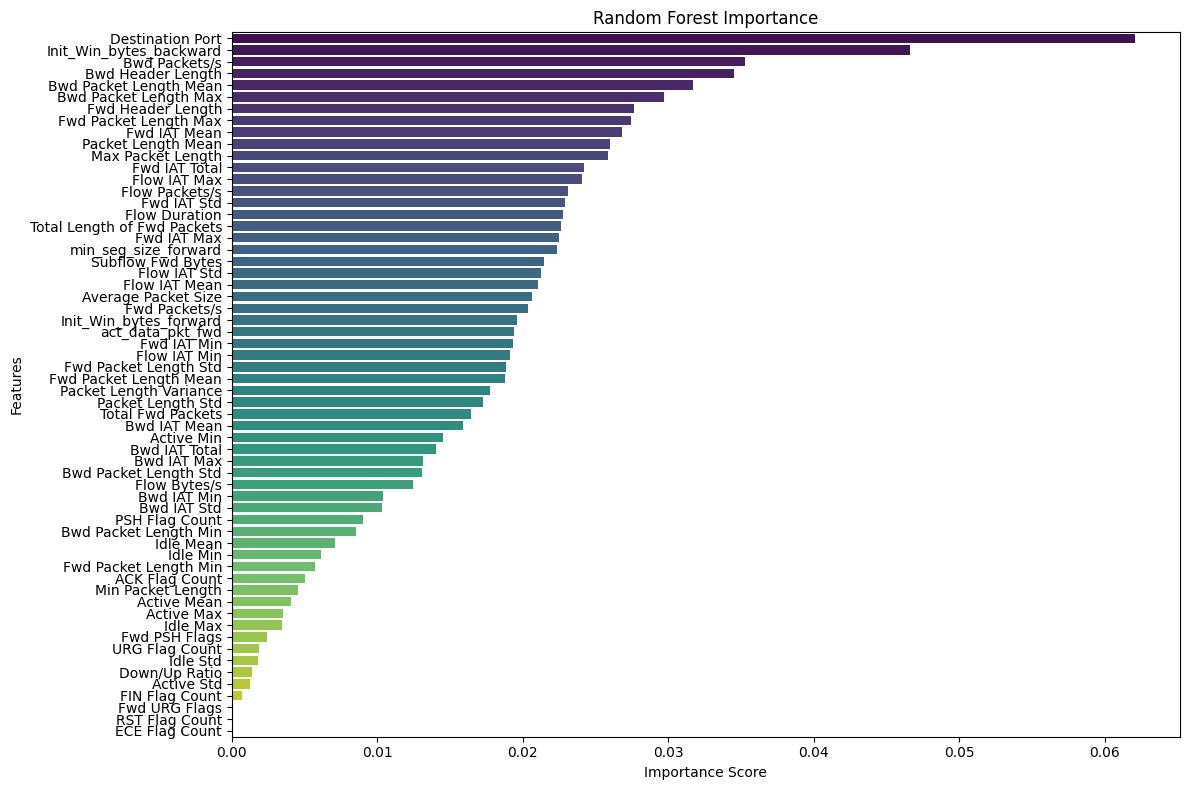

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def rf_feature_importance(df, target_col='Label', sample_fraction=0.1):
    print("--- Memulai Random Forest Feature Importance ---")

    # 1. Persiapan Data (Encoding Label)
    # Kita perlu mengubah Label (String) menjadi Angka
    le = LabelEncoder()
    y = le.fit_transform(df[target_col])

    # Ambil fitur numerik saja (pastikan Label tidak masuk ke X)
    X = df.drop(columns=[target_col])

    # 2. Sampling (PENTING untuk CICIDS2017)
    # Menggunakan 10% data saja sudah cukup representatif untuk melihat feature importance
    # Stratify memastikan proporsi kelas serangan tetap sama
    X_sub, _, y_sub, _ = train_test_split(
        X, y,
        train_size=sample_fraction,
        stratify=y,
        random_state=42
    )
    print(f"Menggunakan sampel data: {X_sub.shape} untuk kalkulasi importance.")

    # 3. Latih Random Forest
    rf = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1,        # Gunakan semua core CPU
        class_weight='balanced' # Penting karena data imbalance
    )
    rf.fit(X_sub, y_sub)

    # 4. Ambil Feature Importances
    importances = rf.feature_importances_
    feature_names = X.columns

    # Buat DataFrame
    rf_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # 5. Visualisasi
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_df, palette='viridis')
    plt.title('Random Forest Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    return rf_df

# --- EKSEKUSI ---
# Pastikan 'Label' ada di kolom Anda.
# Jika sebelumnya sudah dihapus (di langkah Kruskal Wallis), sesuaikan nama variabelnya.
rf_importance_df = rf_feature_importance(raw_df, target_col='Label')

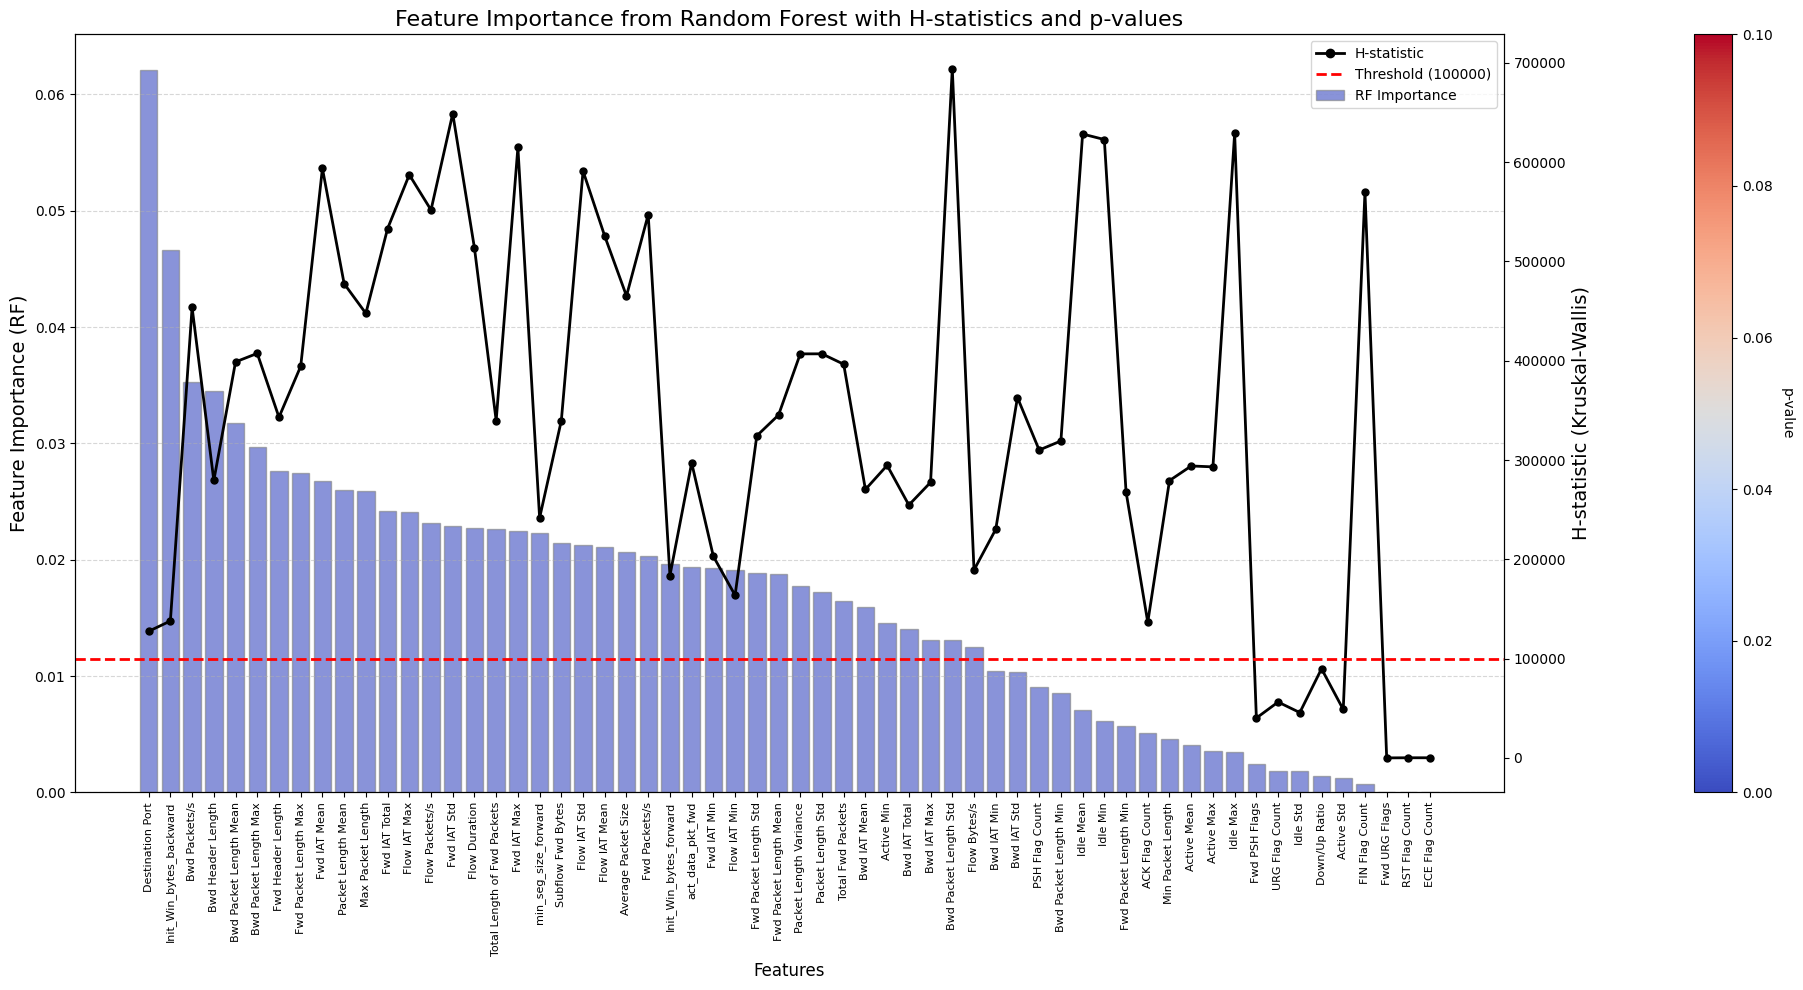

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np

def plot_combined_importance(rf_df, kw_df, h_threshold=100000):
    # 1. GABUNGKAN DATA
    # Menggabungkan hasil RF (rf_df) dan Kruskal-Wallis (kw_df)
    # Asumsi: kw_df index-nya adalah nama fitur, rf_df punya kolom 'Feature'
    merged_df = pd.merge(rf_df, kw_df, left_on='Feature', right_index=True)

    # Sort berdasarkan RF Importance (Descending) agar urutannya rapi seperti gambar
    merged_df = merged_df.sort_values(by='Importance', ascending=False)

    # Siapkan data untuk plot
    features = merged_df['Feature']
    importance = merged_df['Importance']
    h_stat = merged_df['H']
    p_values = merged_df['p']

    # 2. SETUP PLOT (Dual Axis)
    fig, ax1 = plt.subplots(figsize=(20, 10))

    # --- AXIS 1 (KIRI): BAR CHART UNTUK FEATURE IMPORTANCE ---
    # Mewarnai batang berdasarkan p-value (opsional, agar mirip gambar referensi)
    # Jika p-value sangat kecil, warnanya biru (signifikan), jika besar merah (tidak signifikan)
    norm = mcolors.Normalize(vmin=0, vmax=0.1) # Set max p-value untuk skala warna
    cmap = plt.cm.coolwarm
    colors = cmap(norm(p_values.values))

    bars = ax1.bar(features, importance, color=colors, alpha=0.6, edgecolor='grey', label='RF Importance')

    ax1.set_xlabel('Features', fontsize=12)
    ax1.set_ylabel('Feature Importance (RF)', fontsize=14)
    ax1.tick_params(axis='x', rotation=90, labelsize=8)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    # --- AXIS 2 (KANAN): LINE CHART UNTUK H-STATISTIC ---
    ax2 = ax1.twinx()  # Membuat sumbu y kedua

    # Plot garis H-statistic
    line = ax2.plot(features, h_stat, color='black', marker='o', markersize=5,
                    linewidth=2, label='H-statistic')

    ax2.set_ylabel('H-statistic (Kruskal-Wallis)', fontsize=14)

    # --- THRESHOLD LINE ---
    threshold_line = ax2.axhline(y=h_threshold, color='red', linestyle='--', linewidth=2,
                                 label=f'H-statistic Threshold ({h_threshold})')

    # --- COLORBAR UNTUK P-VALUE ---
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax2, pad=0.1)
    cbar.set_label('p-value', rotation=270, labelpad=15)

    # --- LEGEND ---
    # Menggabungkan legend dari kedua axis
    lines_1, labels_1 = ax1.get_legend_handles_labels() # Bar chart handle (biasanya kosong kalau pakai color array)
    lines_2, labels_2 = ax2.get_legend_handles_labels() # Line chart handle

    # Kita buat custom legend agar rapi
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='black', marker='o', lw=2, label='H-statistic'),
        Line2D([0], [0], color='red', linestyle='--', lw=2, label=f'Threshold ({h_threshold})'),
        pd.Series(bars).iloc[0] # Mengambil sampel bar untuk legend
    ]
    ax2.legend(custom_lines, ['H-statistic', f'Threshold ({h_threshold})', 'RF Importance'],
               loc='upper right')

    plt.title('Feature Importance from Random Forest with H-statistics and p-values', fontsize=16)
    plt.tight_layout()
    plt.show()

    return merged_df

# --- EKSEKUSI ---
# Pastikan Anda memasukkan variabel dataframe Anda yang benar di sini
# rf_importance_df = hasil dari kode Random Forest sebelumnya
# df_kw = hasil dari kode Kruskal Wallis sebelumnya

combined_data = plot_combined_importance(rf_importance_df, df_kw, h_threshold=100000)

## destination port di simpan

In [31]:
# drop fitur yang dipilh 1
raw_df = raw_df.drop(columns=[
    'Fwd URG Flags',
    'RST Flag Count',
    'ECE Flag Count',
    'Fwd PSH Flags',
    'Idle Std',
    'Active Std',
    'URG Flag Count',
    'Down/Up Ratio',
])
raw_df.shape
final_features = raw_df.columns.tolist()
print(raw_df.shape)
print("Jumlah fitur:", len(final_features))
print("\nDaftar fitur yang digunakan:\n")
for f in final_features:
    print("-", f)


(2520798, 53)
Jumlah fitur: 53

Daftar fitur yang digunakan:

- Destination Port
- Flow Duration
- Total Fwd Packets
- Total Length of Fwd Packets
- Fwd Packet Length Max
- Fwd Packet Length Min
- Fwd Packet Length Mean
- Fwd Packet Length Std
- Bwd Packet Length Max
- Bwd Packet Length Min
- Bwd Packet Length Mean
- Bwd Packet Length Std
- Flow Bytes/s
- Flow Packets/s
- Flow IAT Mean
- Flow IAT Std
- Flow IAT Max
- Flow IAT Min
- Fwd IAT Total
- Fwd IAT Mean
- Fwd IAT Std
- Fwd IAT Max
- Fwd IAT Min
- Bwd IAT Total
- Bwd IAT Mean
- Bwd IAT Std
- Bwd IAT Max
- Bwd IAT Min
- Fwd Header Length
- Bwd Header Length
- Fwd Packets/s
- Bwd Packets/s
- Min Packet Length
- Max Packet Length
- Packet Length Mean
- Packet Length Std
- Packet Length Variance
- FIN Flag Count
- PSH Flag Count
- ACK Flag Count
- Average Packet Size
- Subflow Fwd Bytes
- Init_Win_bytes_forward
- Init_Win_bytes_backward
- act_data_pkt_fwd
- min_seg_size_forward
- Active Mean
- Active Max
- Active Min
- Idle Mean
- Id

In [32]:
CLEAN_DIR = os.path.join(DATA_DIR, 'clean')
os.makedirs(CLEAN_DIR, exist_ok=True)

csv_path = os.path.join(CLEAN_DIR, 'CICIDS2017_cleann.csv')
parquet_path = os.path.join(CLEAN_DIR, 'CICIDS2017_clean.parquet')

raw_df.to_csv(csv_path, index=False)
raw_df.to_parquet(parquet_path, index=False)

print("Saved:")
print(f" - CSV     : {csv_path}")
print(f" - Parquet : {parquet_path}")

Saved:
 - CSV     : /content/drive/MyDrive/CICIDS2017/clean/CICIDS2017_cleann.csv
 - Parquet : /content/drive/MyDrive/CICIDS2017/clean/CICIDS2017_clean.parquet


## destination port di hapus

In [33]:
# drop fitur yang dipilh2
raw_df = raw_df.drop(columns=[
    'Destination Port'
])
raw_df.shape
final_features = raw_df.columns.tolist()
print(raw_df.shape)
print("Jumlah fitur:", len(final_features))
print("\nDaftar fitur yang digunakan:\n")
for f in final_features:
    print("-", f)


(2520798, 52)
Jumlah fitur: 52

Daftar fitur yang digunakan:

- Flow Duration
- Total Fwd Packets
- Total Length of Fwd Packets
- Fwd Packet Length Max
- Fwd Packet Length Min
- Fwd Packet Length Mean
- Fwd Packet Length Std
- Bwd Packet Length Max
- Bwd Packet Length Min
- Bwd Packet Length Mean
- Bwd Packet Length Std
- Flow Bytes/s
- Flow Packets/s
- Flow IAT Mean
- Flow IAT Std
- Flow IAT Max
- Flow IAT Min
- Fwd IAT Total
- Fwd IAT Mean
- Fwd IAT Std
- Fwd IAT Max
- Fwd IAT Min
- Bwd IAT Total
- Bwd IAT Mean
- Bwd IAT Std
- Bwd IAT Max
- Bwd IAT Min
- Fwd Header Length
- Bwd Header Length
- Fwd Packets/s
- Bwd Packets/s
- Min Packet Length
- Max Packet Length
- Packet Length Mean
- Packet Length Std
- Packet Length Variance
- FIN Flag Count
- PSH Flag Count
- ACK Flag Count
- Average Packet Size
- Subflow Fwd Bytes
- Init_Win_bytes_forward
- Init_Win_bytes_backward
- act_data_pkt_fwd
- min_seg_size_forward
- Active Mean
- Active Max
- Active Min
- Idle Mean
- Idle Max
- Idle Min
-

In [34]:
CLEAN_DIR = os.path.join(DATA_DIR, 'clean')
os.makedirs(CLEAN_DIR, exist_ok=True)

csv_path = os.path.join(CLEAN_DIR, 'CICIDS2017_clean_no_desport.csv')
parquet_path = os.path.join(CLEAN_DIR, 'CICIDS2017_clean_nodesport.parquet')

raw_df.to_csv(csv_path, index=False)
raw_df.to_parquet(parquet_path, index=False)

print("Saved:")
print(f" - CSV     : {csv_path}")
print(f" - Parquet : {parquet_path}")

Saved:
 - CSV     : /content/drive/MyDrive/CICIDS2017/clean/CICIDS2017_clean_no_desport.csv
 - Parquet : /content/drive/MyDrive/CICIDS2017/clean/CICIDS2017_clean_nodesport.parquet


# 5. MODEL RANDOM FOREST

Collected 500000 rows for group 'Normal Traffic' (target 500000)
Collected 193745 rows for group 'DoS' (target 200000)
Collected 90000 rows for group 'DDoS' (target 90000)
Collected 70000 rows for group 'Port Scanning' (target 70000)
Collected 7000 rows for group 'Brute Force' (target 7000)
Collected 1984 rows for group 'Bots' (target 2000)
Collected 2000 rows for group 'Web Attacks' (target 2000)
Collected shape: (864729, 53) in 18.7s
Binary counts: {0: 500000, 1: 364729}
Train/Test shapes: (691783, 52) (172946, 52)
Training RandomForest (binary)...
Trained in 863.7s
Binary confusion matrix (tn,fp,fn,tp): (np.int64(99920), np.int64(80), np.int64(117), np.int64(72829))
Accuracy: 0.9988609161241081


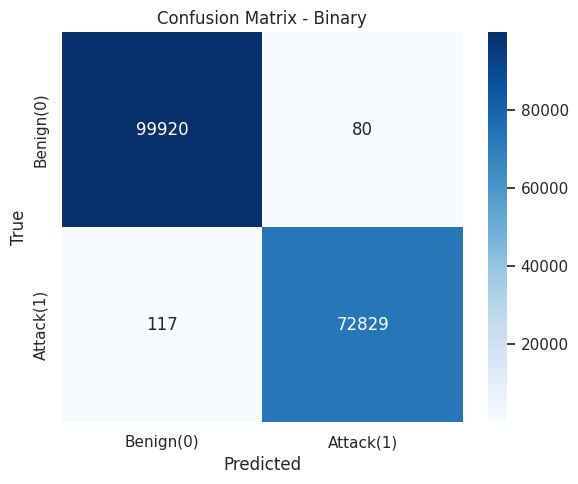

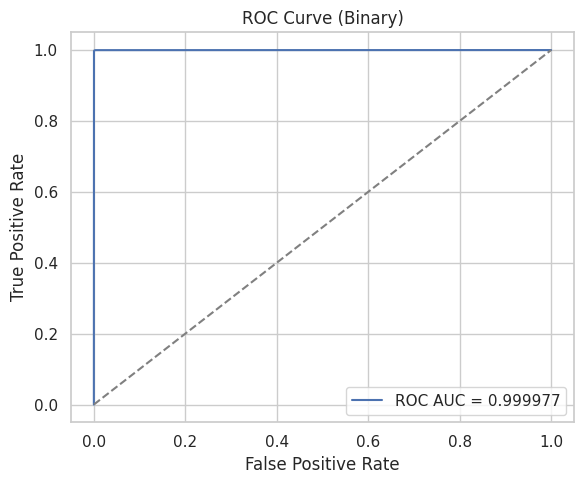

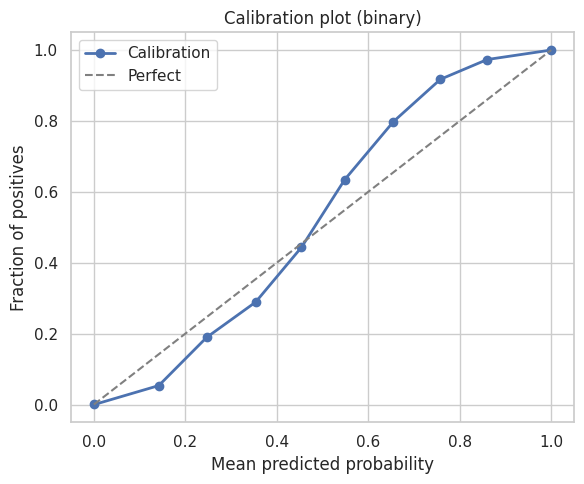

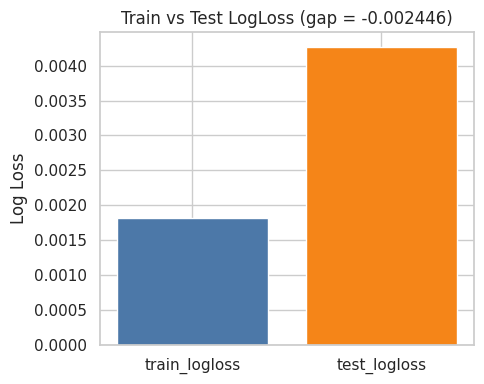

Train logloss: 0.0018189694360671255 Test logloss: 0.004264858321837209


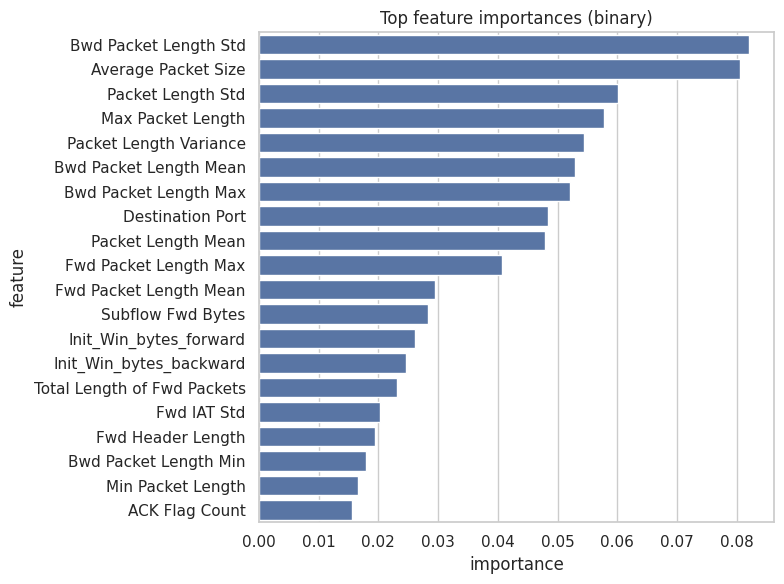

All plots and artifacts saved to: /content/drive/MyDrive/startRF_binary_plots

=== CLASSIFICATION REPORT (PER LABEL) ===
              precision    recall  f1-score   support

  Benign (0)   0.998830  0.999200  0.999015    100000
  Attack (1)   0.998903  0.998396  0.998649     72946

    accuracy                       0.998861    172946
   macro avg   0.998867  0.998798  0.998832    172946
weighted avg   0.998861  0.998861  0.998861    172946


=== BEST THRESHOLD (ROC / Youden J) ===
Best Threshold (ROC): 0.449470

=== Classification Report (Best ROC Threshold) ===
              precision    recall  f1-score   support

  Benign (0)   0.999100  0.998950  0.999025    100000
  Attack (1)   0.998561  0.998766  0.998664     72946

    accuracy                       0.998872    172946
   macro avg   0.998830  0.998858  0.998844    172946
weighted avg   0.998873  0.998872  0.998872    172946


=== BEST THRESHOLD (Max F1) ===
Best Threshold (F1): 0.510000
Best F1 Score     : 0.998670

=== Clas

In [35]:
# ONE-CELL: Build binary RF (Benign=0, Attack=1) + Confusion matrix, ROC AUC, Calibration, Gap-loss, Feature importances
# Pastikan Drive sudah dimount: from google.colab import drive; drive.mount('/content/drive')

import os
import time
import gc
import json
import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_curve,
    auc,
    log_loss,
    classification_report,
)
from sklearn.calibration import calibration_curve

sns.set(style="whitegrid")

# ---------- CONFIG ----------
CSV_PATH = "/content/drive/MyDrive/CICIDS2017/clean/CICIDS2017_cleann.csv"
OUT_DIR = "/content/drive/MyDrive/startRF_binary_plots"
os.makedirs(OUT_DIR, exist_ok=True)

RANDOM_STATE = 42
CHUNK = 200_000

# target group counts (we'll collect like contoh lalu convert to binary)
TARGET_COUNTS = {
    "Normal Traffic": 500000,
    "DoS": 200000,
    "DDoS": 90000,
    "Port Scanning": 70000,
    "Brute Force": 7000,
    "Bots": 2000,
    "Web Attacks": 2000,
}

group_map = {
    "BENIGN": "Normal Traffic",
    "DoS Hulk": "DoS",
    "DoS GoldenEye": "DoS",
    "DoS slowloris": "DoS",
    "DoS Slowhttptest": "DoS",
    "DDoS": "DDoS",
    "PortScan": "Port Scanning",
    "SSH-Patator": "Brute Force",
    "FTP-Patator": "Brute Force",
    "Web Attack � Brute Force": "Web Attacks",
    "Web Attack � XSS": "Web Attacks",
    "Web Attack � Sql Injection": "Web Attacks",
    "Web Attack - Brute Force": "Web Attacks",
    "Web Attack - XSS": "Web Attacks",
    "Web Attack - Sql Injection": "Web Attacks",
    "Bot": "Bots",
    "Infiltration": "Bots",
}

RF_PARAMS = {
    "n_estimators": 200,
    "max_depth": 30,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "max_features": "sqrt",
    "random_state": RANDOM_STATE,
    "n_jobs": 1,
    "class_weight": "balanced_subsample",
}


# ---------- helper: collect balanced groups ----------
def collect_balanced(path, target_counts, group_map, chunksize=200000, random_state=42):
    # detect label column
    peek = pd.read_csv(path, nrows=1000)
    label_col = None
    candidates = [
        "Attack Type",
        "Label",
        "label",
        "Label_bin",
        "Category",
        "Class",
        "attack",
        "Attack",
    ]
    for c in candidates:
        if c in peek.columns:
            label_col = c
            break

    if label_col is None:
        obj_cols = [
            c
            for c in peek.columns
            if peek[c].dtype == "object"
            or str(peek[c].dtype).startswith("category")
        ]
        if obj_cols:
            label_col = sorted(obj_cols, key=lambda cc: peek[cc].nunique())[0]
        else:
            raise SystemExit("Cannot auto-detect label column.")

    buffers = {k: [] for k in target_counts}
    got = {k: 0 for k in target_counts}
    total_read = 0

    for chunk in pd.read_csv(path, chunksize=chunksize):
        total_read += len(chunk)
        mapped = chunk[label_col].map(group_map).fillna(chunk[label_col])
        chk = chunk.copy()
        chk["__grp__"] = mapped

        for grp, grp_df in chk.groupby("__grp__"):
            if grp in target_counts:
                need = target_counts[grp] - got[grp]
                if need <= 0:
                    continue
                take_n = min(need, len(grp_df))
                if take_n == len(grp_df):
                    part = grp_df
                else:
                    part = grp_df.sample(n=take_n, random_state=random_state)
                buffers[grp].append(part.drop(columns=["__grp__"]))
                got[grp] += take_n

        if all(got[g] >= target_counts[g] for g in target_counts):
            break

    parts = []
    for g in target_counts:
        if not buffers[g]:
            print(f"Warning: no samples for group {g}")
            continue
        dfg = pd.concat(buffers[g], ignore_index=True)
        if len(dfg) > target_counts[g]:
            dfg = dfg.sample(n=target_counts[g], random_state=random_state).reset_index(
                drop=True
            )
        parts.append(dfg)
        print(f"Collected {len(dfg)} rows for group '{g}' (target {target_counts[g]})")

    full = pd.concat(parts, ignore_index=True)
    return full, label_col


# ---------- collect ----------
print("Collecting balanced groups (chunked)...")
t0 = time.time()
balanced_df, label_col = collect_balanced(
    CSV_PATH, TARGET_COUNTS, group_map, chunksize=CHUNK, random_state=RANDOM_STATE
)
print("Collected shape:", balanced_df.shape, "in {:.1f}s".format(time.time() - t0))

# ---------- create binary labels ----------
balanced_df["group_label"] = (
    balanced_df[label_col].map(group_map).fillna(balanced_df[label_col])
)
balanced_df["binary_label"] = balanced_df["group_label"].apply(
    lambda s: 0
    if str(s).lower().startswith("normal") or "benign" in str(s).lower()
    else 1
)
print("Binary counts:", balanced_df["binary_label"].value_counts().to_dict())

# ---------- prepare features/targets ----------
X = balanced_df.drop(columns=[label_col, "group_label", "binary_label"])
y = balanced_df["binary_label"].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train/Test shapes:", X_train_raw.shape, X_test_raw.shape)

# scale numeric columns
num_cols = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()
if not num_cols:
    raise SystemExit("No numeric features found to train on.")
scaler = RobustScaler()

X_train = X_train_raw.copy()
X_test = X_test_raw.copy()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train_vals = X_train[num_cols].values
X_test_vals = X_test[num_cols].values

# ---------- train RF ----------
print("Training RandomForest (binary)...")
t0 = time.time()
rf = RandomForestClassifier(**RF_PARAMS)
rf.fit(X_train_vals, y_train)
train_time = time.time() - t0
print("Trained in {:.1f}s".format(train_time))

# ---------- predictions & proba ----------
proba_test = (
    rf.predict_proba(X_test_vals)[:, 1]
    if hasattr(rf, "predict_proba")
    else rf.predict(X_test_vals).astype(float)
)
pred_test = (proba_test >= 0.5).astype(int)

# ---------- confusion matrix ----------
cm = confusion_matrix(y_test, pred_test, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(y_test, pred_test)
print("Binary confusion matrix (tn,fp,fn,tp):", (tn, fp, fn, tp))
print("Accuracy:", acc)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Benign(0)", "Attack(1)"],
    yticklabels=["Benign(0)", "Attack(1)"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Binary")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_binary.png"))
plt.show()

# ---------- ROC AUC ----------
fpr, tpr, thr = roc_curve(y_test, proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.6f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Binary)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "roc_auc_binary.png"))
plt.show()

# ---------- Calibration plot ----------
prob_true, prob_pred = calibration_curve(y_test, proba_test, n_bins=10)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker="o", linewidth=2, label="Calibration")
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfect")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration plot (binary)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "calibration_binary.png"))
plt.show()

# ---------- Gap-loss ----------
train_subset_n = min(10000, X_train_vals.shape[0])
train_proba_sub = (
    rf.predict_proba(X_train_vals[:train_subset_n])[:, 1]
    if hasattr(rf, "predict_proba")
    else rf.predict(X_train_vals[:train_subset_n]).astype(float)
)
train_logloss = log_loss(y_train[:train_subset_n], train_proba_sub, labels=[0, 1])
test_logloss = log_loss(y_test, proba_test, labels=[0, 1])

plt.figure(figsize=(5, 4))
plt.bar(["train_logloss", "test_logloss"], [train_logloss, test_logloss], color=[
    "#4c78a8", "#f58518"
])
plt.title(f"Train vs Test LogLoss (gap = {train_logloss - test_logloss:.6f})")
plt.ylabel("Log Loss")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "gap_loss_binary.png"))
plt.show()

print("Train logloss:", train_logloss, "Test logloss:", test_logloss)

# ---------- Feature importances ----------
fi = rf.feature_importances_
fi_df = (
    pd.DataFrame({"feature": num_cols, "importance": fi})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)
fi_df.to_csv(os.path.join(OUT_DIR, "feature_importances_binary.csv"), index=False)

plt.figure(figsize=(8, 6))
topk = min(20, len(fi_df))
sns.barplot(x=fi_df.importance.head(topk), y=fi_df.feature.head(topk))
plt.title("Top feature importances (binary)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "feature_importances_binary.png"))
plt.show()

# ---------- Save model + metrics ----------
joblib.dump(rf, os.path.join(OUT_DIR, "rf_binary.joblib"))
joblib.dump(scaler, os.path.join(OUT_DIR, "scaler_binary.joblib"))

with open(os.path.join(OUT_DIR, "binary_metrics.json"), "w") as f:
    json.dump(
        {
            "train_time_s": float(train_time),
            "accuracy": float(acc),
            "roc_auc": float(roc_auc),
            "tn": int(tn),
            "fp": int(fp),
            "fn": int(fn),
            "tp": int(tp),
            "train_logloss": float(train_logloss),
            "test_logloss": float(test_logloss),
        },
        f,
        indent=2,
    )

print("All plots and artifacts saved to:", OUT_DIR)
# ---------- done ----------
gc.collect()

# ---------- Classification Report Per Label ----------
class_names = ["Benign (0)", "Attack (1)"]

report_text = classification_report(
    y_test, pred_test, target_names=class_names, digits=6, zero_division=0
)

print("\n=== CLASSIFICATION REPORT (PER LABEL) ===")
print(report_text)

# Save to file
with open(os.path.join(OUT_DIR, "classification_report_binary.txt"), "w") as f:
    f.write(report_text)

# ---------- BEST THRESHOLD (ROC - Youden's J) ----------
fpr, tpr, thresholds = roc_curve(y_test, proba_test)
youden = tpr - fpr
best_thr_roc = thresholds[np.argmax(youden)]

print("\n=== BEST THRESHOLD (ROC / Youden J) ===")
print(f"Best Threshold (ROC): {best_thr_roc:.6f}")

# Evaluate using best ROC threshold
pred_best_roc = (proba_test >= best_thr_roc).astype(int)
report_roc = classification_report(
    y_test, pred_best_roc, target_names=["Benign (0)", "Attack (1)"], digits=6, zero_division=0
)
print("\n=== Classification Report (Best ROC Threshold) ===")
print(report_roc)

# ---------- BEST THRESHOLD (Max F1 Score) ----------
threshold_grid = np.linspace(0.0, 1.0, 101)
f1_scores = []

from sklearn.metrics import f1_score  # kept inline to preserve original structure

for th in threshold_grid:
    pred_temp = (proba_test >= th).astype(int)
    f1_temp = f1_score(y_test, pred_temp, zero_division=0)
    f1_scores.append(f1_temp)

best_thr_f1 = threshold_grid[np.argmax(f1_scores)]
best_f1_value = max(f1_scores)

print("\n=== BEST THRESHOLD (Max F1) ===")
print(f"Best Threshold (F1): {best_thr_f1:.6f}")
print(f"Best F1 Score     : {best_f1_value:.6f}")

# Evaluate using best F1 threshold
pred_best_f1 = (proba_test >= best_thr_f1).astype(int)
report_f1 = classification_report(
    y_test, pred_best_f1, target_names=["Benign (0)", "Attack (1)"], digits=6, zero_division=0
)
print("\n=== Classification Report (Best F1 Threshold) ===")
print(report_f1)

# ---------- SAVE THRESHOLDS ----------
thresholds_dict = {
    "default_threshold": 0.5,
    "best_threshold_roc": float(best_thr_roc),
    "best_threshold_f1": float(best_thr_f1),
    "best_f1_value": float(best_f1_value),
}

with open(os.path.join(OUT_DIR, "best_thresholds.json"), "w") as f:
    json.dump(thresholds_dict, f, indent=2)

print("\nSaved threshold info to:", os.path.join(OUT_DIR, "best_thresholds.json"))


distillation

In [37]:
# ONE-CELL: Distill sklearn RandomForest -> Keras -> TFLite (float32)
# Run after mounting Drive: from google.colab import drive; drive.mount('/content/drive')

import os
import time
import json
import joblib

import numpy as np
import pandas as pd

from pathlib import Path

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, log_loss

# ---------- USER CONFIG ----------
RF_PATH = "/content/drive/MyDrive/startRF_binary_plots/rf_binary.joblib"  # path to your saved sklearn RF
SCALER_PATH = "/content/drive/MyDrive/startRF_binary_plots/scaler_binary.joblib"  # path to scaler (optional)
CSV_PATH = "/content/drive/MyDrive/CICIDS2017/clean/CICIDS2017_cleann.csv"  # to sample data if needed
OUT_DIR = "/content/drive/MyDrive/startRF_tflite"
os.makedirs(OUT_DIR, exist_ok=True)

SAMPLE_SIZE = 200_000  # size to sample from CSV for distillation (tune by RAM)
RANDOM_STATE = 42
BATCH_SIZE = 2048
EPOCHS = 40
PATIENCE = 5

# ---------- 1) load RandomForest ----------
if not os.path.exists(RF_PATH):
    raise SystemExit(f"RandomForest model not found at {RF_PATH}. Please set RF_PATH to the joblib file.")

print("Loading RandomForest from:", RF_PATH)
rf = joblib.load(RF_PATH)

# ---------- 2) prepare dataset (numeric features) ----------
# Try to load scaler if present; otherwise compute scaler from sampled numeric columns
use_saved_scaler = False
if os.path.exists(SCALER_PATH):
    try:
        scaler = joblib.load(SCALER_PATH)
        use_saved_scaler = True
        print("Loaded scaler from:", SCALER_PATH)
    except Exception as e:
        print("Could not load scaler, will fit a new one. Error:", e)


# Sample CSV (chunk-safe)
def sample_csv_numerics(csv_path, sample_size, random_state=RANDOM_STATE, chunksize=200_000):
    total_est = 2520798
    frac = min(1.0, sample_size / total_est)
    parts = []
    for chunk in pd.read_csv(csv_path, chunksize=chunksize):
        try:
            parts.append(chunk.sample(frac=frac, random_state=random_state))
        except Exception:
            parts.append(
                chunk.sample(
                    n=min(len(chunk), max(1, int(sample_size / 10))),
                    random_state=random_state,
                )
            )
    df = pd.concat(parts, ignore_index=True)
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=random_state).reset_index(drop=True)
    return df


print("Sampling CSV to build distillation dataset (this may take some time)...")
t0 = time.time()
df_sample = sample_csv_numerics(CSV_PATH, SAMPLE_SIZE)
print("Sampled rows:", len(df_sample), "in {:.1f}s".format(time.time() - t0))

# detect label column and drop it
candidates = [
    "Attack Type",
    "Label",
    "label",
    "Label_bin",
    "Category",
    "Class",
    "attack",
    "Attack",
]
label_col = None
for c in candidates:
    if c in df_sample.columns:
        label_col = c
        break

# choose numeric columns only for features (same approach used in earlier scripts)
num_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
if label_col and label_col in num_cols:
    num_cols.remove(label_col)
if not num_cols:
    raise SystemExit("No numeric feature columns found in sampled CSV.")

print("Using numeric feature columns count:", len(num_cols))

X_full = df_sample[num_cols].astype("float32").values

# Fit or use scaler
if not use_saved_scaler:
    print("Fitting RobustScaler on sampled numeric features...")
    scaler = RobustScaler()
    scaler.fit(X_full)
else:
    print("Using loaded scaler for transformation.")

X_scaled = scaler.transform(X_full)

# ---------- 3) get RF probabilities (distillation targets) ----------
if hasattr(rf, "predict_proba"):
    y_proba = rf.predict_proba(X_scaled)[:, 1]  # probabilities for positive class
else:
    # fallback: use rf.predict (0/1). Distillation works better with probabilities.
    y_proba = rf.predict(X_scaled).astype(float)

# ---------- optional: save the sample inputs used for distillation ----------
np.savez_compressed(os.path.join(OUT_DIR, "distill_sample.npz"), X_scaled=X_scaled, y_proba=y_proba)

# ---------- 4) split for train/val ----------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_scaled, y_proba, test_size=0.15, random_state=RANDOM_STATE, shuffle=True
)
print("Shapes: train", X_tr.shape, "val", X_val.shape)

# ---------- 5) build small Keras model to mimic RF probabilities ----------
input_dim = X_tr.shape[1]


def build_small_mlp(input_dim):
    inp = keras.Input(shape=(input_dim,), dtype="float32")
    x = layers.Dense(128, activation="relu")(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)  # output probability
    m = keras.Model(inputs=inp, outputs=out)
    return m


model = build_small_mlp(input_dim)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()

# ---------- 6) callbacks ----------
es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True, verbose=1)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

# ---------- 7) train to distill (regress to RF probabilities) ----------
history = model.fit(
    X_tr,
    y_tr,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlr],
    verbose=2,
)

# ---------- 8) evaluate distillation quality ----------
y_val_pred = model.predict(X_val).ravel()
mse = mean_squared_error(y_val, y_val_pred)
roc = roc_auc_score((y_val >= 0.5).astype(int), y_val_pred)  # how well distilled model separates
print(f"Distillation val MSE: {mse:.6f}, ROC AUC vs RF labels: {roc:.6f}")

# ---------- 9) convert to TFLite (float32) ----------
print("Converting Keras model to TFLite (float32)...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_out = os.path.join(OUT_DIR, "rfixed.tflite")
with open(tflite_out, "wb") as f:
    f.write(tflite_model)

# ---------- 10) save artifacts ----------
keras_out = os.path.join(OUT_DIR, "rf_distilled_keras.h5")
model.save(keras_out)
joblib.dump(scaler, os.path.join(OUT_DIR, "distill_robust_scaler.joblib"))
joblib.dump(rf, os.path.join(OUT_DIR, "rf_source_for_distill.joblib"))

with open(os.path.join(OUT_DIR, "distill_metrics.json"), "w") as f:
    json.dump({"distill_val_mse": float(mse), "distill_val_roc_auc": float(roc)}, f, indent=2)

print("Saved Keras model, scaler, source RF, and tflite to:", OUT_DIR)
print("TFLite file:", tflite_out)


Loading RandomForest from: /content/drive/MyDrive/startRF_binary_plots/rf_binary.joblib
Loaded scaler from: /content/drive/MyDrive/startRF_binary_plots/scaler_binary.joblib
Sampling CSV to build distillation dataset (this may take some time)...
Sampled rows: 200000 in 39.9s
Using numeric feature columns count: 52
Using loaded scaler for transformation.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


Shapes: train (170000, 52) val (30000, 52)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         6,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,153 (67.00 KB)

 Trainable params: 17,153 (67.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
84/84 - 4s - 49ms/step - loss: 0.0871 - root_mean_squared_error: 0.2952 - val_loss: 0.0649 - val_root_mean_squared_error: 0.2547 - learning_rate: 1.0000e-03
Epoch 2/40
84/84 - 1s - 14ms/step - loss: 0.0636 - root_mean_squared_error: 0.2521 - val_loss: 0.0610 - val_root_mean_squared_error: 0.2470 - learning_rate: 1.0000e-03
Epoch 3/40
84/84 - 2s - 18ms/step - loss: 0.0601 - root_mean_squared_error: 0.2451 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2426 - learning_rate: 1.0000e-03
Epoch 4/40
84/84 - 2s - 26ms/step - loss: 0.0496 - root_mean_squared_error: 0.2227 - val_loss: 0.0457 - val_root_mean_squared_error: 0.2138 - learning_rate: 1.0000e-03
Epoch 5/40
84/84 - 1s - 14ms/step - loss: 0.0401 - root_mean_squared_error: 0.2001 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1938 - learning_rate: 1.0000e-03
Epoch 6/40
84/84 - 1s - 14ms/step - loss: 0.0368 - root_mean_squared_error: 0.1919 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1753 - learning_rate: 1.0

Saved Keras model, scaler, source RF, and tflite to: /content/drive/MyDrive/startRF_tflite
TFLite file: /content/drive/MyDrive/startRF_tflite/rfixed.tflite
